# Dating S.bovis admixture

Neal Platt 2021

In [1]:
import os
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import Image
from matplotlib.pyplot import figure
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm import tqdm

/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
proj_dir = "/master/nplatt/sch_hae_scan"
results_dir = f"{proj_dir}/results"
os.chdir(results_dir)

In [3]:
Path(f"{results_dir}/dating_admixture").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/dating_admixture")

In [4]:
pca_df = pd.read_csv(f"{proj_dir}/results/pca/pca_df.csv", sep=",")
pca_df = pca_df[["sample_name", "kmeans_label", "country"]]

In [5]:
adm_df = pd.read_csv(f"{proj_dir}/results/admixture/k2_adm_df.csv", sep=",")

In [6]:
adm_df = adm_df[["k2_sh", "k2_sb", "sample_name"]]

In [7]:
info_df = pca_df.merge(adm_df, on="sample_name")
info_df

,sample_name,kmeans_label,country,k2_sh,k2_sb
0,Sb_NG_au_1.2,sb,nigeria,0.000010,0.999990
1,Sb_NG_au_2.10,sb,nigeria,0.000010,0.999990
2,Sb_NG_au_2.13,sb,nigeria,0.000010,0.999990
3,Sb_NG_au_2.5,sb,nigeria,0.000010,0.999990
4,Sb_NG_au_2.6,sb,nigeria,0.000010,0.999990
...,...,...,...,...,...
157,ssp_niger_libore_166,sh_nw,niger,0.961084,0.038916
158,ssp_niger_libore_167,sh_nw,niger,0.959690,0.040310
159,ssp_niger_libore_168,sh_nw,niger,0.957791,0.042209
160,ssp_niger_libore_169,sh_nw,niger,0.957927,0.042073


## Size distribution of Sb alleles in SH NW

In [11]:
# read in rfmix data
df = pd.read_csv("../rfmix/rfmix_df.csv")

In [12]:
df["n_bp"] = df["e_pos"] - df["s_pos"] + 1

In [13]:
df["n_bp"] = df["e_pos"] - df["s_pos"]

In [14]:
genome_size = df["n_bp"].sum()

In [15]:
def find_consecutive_regions_same_chrom(df, sample_id, target_allele):
    regions = []
    start_idx = None
    current_chrom = None
    length = 0
    start_pos = None
    end_pos = None

    for idx, row in df.iterrows():
        if row[sample_id] == target_allele and row["chrom"] == current_chrom:
            length += row["n_bp"]
            end_pos = row["e_pos"]
            if start_idx is None:
                start_idx = idx
                start_pos = row["s_pos"]
        else:
            if start_idx is not None:
                regions.append(
                    (current_chrom, start_idx, idx - 1, length, start_pos, end_pos)
                )
                start_idx = None
                length = 0
                start_pos = None
                end_pos = None
            if row[sample_id] == target_allele:
                start_idx = idx
                current_chrom = row["chrom"]
                length = row["n_bp"]
                start_pos = row["s_pos"]
            else:
                current_chrom = None
    if start_idx is not None:
        regions.append(
            (current_chrom, start_idx, len(df) - 1, length, start_pos, end_pos)
        )

    # Convert the list of tuples to a DataFrame
    regions_df = pd.DataFrame(
        regions, columns=["chrom", "start_idx", "end_idx", "length", "s_pos", "e_pos"]
    )
    return regions_df

In [16]:
nw_samples = list(pca_df.loc[pca_df["kmeans_label"] == "sh_nw", "sample_name"].values)

In [17]:
samples = df.columns[6:-1]
sb_allele = 0

# make empty dataframe
column_names = ["sample", "pop", "sb_q", "med_l", "min_l", "max_l", "mean_l", "g"]
empty_df = pd.DataFrame(columns=column_names)


meds = []
mins = []
maxs = []
means = []
pops = []
qs = []
gs = []
used_samples = []
failed_samples = []
countries = []
chroms = []
starts = []
stops = []

for sample in tqdm(nw_samples):
    for hap in [0, 1]:
        hap_sample = f"{sample}.{hap}"
        try:
            pop = info_df.loc[info_df["sample_name"] == sample, "kmeans_label"].values[
                0
            ]
            # q   = info_df.loc[info_df["sample_name"] == sample, "k2_sh"].values[0]

            pops.append(pop)

            used_samples.append(hap_sample)

            regions_df = find_consecutive_regions_same_chrom(df, hap_sample, sb_allele)

            q = 1 - (regions_df["length"].sum() / genome_size)
            qs.append(q)

            meds.append(regions_df["length"].median())
            mins.append(regions_df["length"].min())
            maxs.append(regions_df["length"].max())
            means.append(regions_df["length"].mean())

            # get the longest region:
            longest_info = regions_df.loc[regions_df["length"].idxmax()]
            chroms.append(longest_info["chrom"])
            starts.append(longest_info["s_pos"])
            stops.append(longest_info["e_pos"])

            l = meds[-1]

            gs.append(1 / ((l * 3.3e-8) * q))
        except:
            failed_samples.append(hap_sample)

g_df = pd.DataFrame(
    columns=[
        "hap",
        "pop",
        "q",
        "med_l",
        "mean_l",
        "min_l",
        "max_l",
        "g",
        "longest_chrom",
        "longest_start",
        "longest_stop",
    ]
)

g_df["hap"] = used_samples
g_df["pop"] = pops
g_df["q"] = qs
g_df["med_l"] = meds
g_df["mean_l"] = means
g_df["min_l"] = mins
g_df["max_l"] = maxs
g_df["g"] = gs
g_df["longest_chrom"] = chroms
g_df["longest_start"] = starts
g_df["longest_stop"] = stops

g_df.to_csv("introgression_dates_per_indv.csv", sep=",", header=True, index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [04:25<00:00,  3.16s/it]


In [19]:
sample_ids = []
countries = []

for index, row in g_df.iterrows():
    hap_id = row["hap"]
    sample_id = ".".join(hap_id.split(".")[:-1])
    country = pca_df.loc[pca_df["sample_name"] == sample_id, "country"].values[0]

    sample_ids.append(sample_id)
    countries.append(country)


g_df["sample_id"] = sample_ids
g_df["country"] = countries

g_df.to_csv("introgression_dates_per_indv.csv", sep=",", header=True, index=False)
g_df

,hap,pop,q,med_l,mean_l,min_l,max_l,g,longest_chrom,longest_start,longest_stop,sample_id,country
0,Sh_NG_eb_6_2.0,sh_nw,0.780612,69870.5,150307.043706,7422,2466909,555.593433,NC_067200.1,2804,2469713.0,Sh_NG_eb_6_2,nigeria
1,Sh_NG_eb_6_2.1,sh_nw,0.775547,75100.0,154587.479789,6974,2492129,520.280728,NC_067200.1,2804,2494933.0,Sh_NG_eb_6_2,nigeria
2,Sh_NG_ed_1_3.0,sh_nw,0.912472,55326.0,102392.017910,6635,1670464,600.257254,NC_067200.1,213953,1884417.0,Sh_NG_ed_1_3,nigeria
3,Sh_NG_ed_1_3.1,sh_nw,0.907377,57256.5,104907.109827,5897,1752127,583.275195,NC_067200.1,214473,1966600.0,Sh_NG_ed_1_3,nigeria
4,Sh_NG_ed_3_2.0,sh_nw,0.871908,60500.0,131064.582245,9188,2340942,574.460311,NC_067200.1,2804,2343746.0,Sh_NG_ed_3_2,nigeria
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,ssp_niger_libore_167.1,sh_nw,0.935915,53894.0,119025.000000,4963,2018683,600.771586,NC_067196.1,124225,2142908.0,ssp_niger_libore_167,niger
160,ssp_niger_libore_168.0,sh_nw,0.923197,66169.0,142645.483412,6491,2846202,496.063328,NC_067200.1,162464,3008666.0,ssp_niger_libore_168,niger
161,ssp_niger_libore_168.1,sh_nw,0.922371,73879.0,135811.419643,7397,2717858,444.691946,NC_067200.1,207829,2925687.0,ssp_niger_libore_168,niger
162,ssp_niger_libore_169.0,sh_nw,0.927961,92604.0,173197.803681,7815,2466909,352.635969,NC_067200.1,2804,2469713.0,ssp_niger_libore_169,niger


In [20]:
g_df = pd.read_csv("introgression_dates_per_indv.csv", sep=",")
g_df

,hap,pop,q,med_l,mean_l,min_l,max_l,g,longest_chrom,longest_start,longest_stop,sample_id,country
0,Sh_NG_eb_6_2.0,sh_nw,0.780612,69870.5,150307.043706,7422,2466909,555.593433,NC_067200.1,2804,2469713.0,Sh_NG_eb_6_2,nigeria
1,Sh_NG_eb_6_2.1,sh_nw,0.775547,75100.0,154587.479789,6974,2492129,520.280728,NC_067200.1,2804,2494933.0,Sh_NG_eb_6_2,nigeria
2,Sh_NG_ed_1_3.0,sh_nw,0.912472,55326.0,102392.017910,6635,1670464,600.257254,NC_067200.1,213953,1884417.0,Sh_NG_ed_1_3,nigeria
3,Sh_NG_ed_1_3.1,sh_nw,0.907377,57256.5,104907.109827,5897,1752127,583.275195,NC_067200.1,214473,1966600.0,Sh_NG_ed_1_3,nigeria
4,Sh_NG_ed_3_2.0,sh_nw,0.871908,60500.0,131064.582245,9188,2340942,574.460311,NC_067200.1,2804,2343746.0,Sh_NG_ed_3_2,nigeria
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,ssp_niger_libore_167.1,sh_nw,0.935915,53894.0,119025.000000,4963,2018683,600.771586,NC_067196.1,124225,2142908.0,ssp_niger_libore_167,niger
160,ssp_niger_libore_168.0,sh_nw,0.923197,66169.0,142645.483412,6491,2846202,496.063328,NC_067200.1,162464,3008666.0,ssp_niger_libore_168,niger
161,ssp_niger_libore_168.1,sh_nw,0.922371,73879.0,135811.419643,7397,2717858,444.691946,NC_067200.1,207829,2925687.0,ssp_niger_libore_168,niger
162,ssp_niger_libore_169.0,sh_nw,0.927961,92604.0,173197.803681,7815,2466909,352.635969,NC_067200.1,2804,2469713.0,ssp_niger_libore_169,niger


In [21]:
g_df["g"].median()

426.41632977423694

In [22]:
g_df.loc[(g_df["country"] == "nigeria"), "med_l"].min()

45065.0

In [24]:
g_df.loc[(g_df["country"] == "nigeria"), "med_l"].max()

97609.0

In [23]:
mean_g_nw = (
    g_df.loc[g_df["pop"] == "sh_nw"]
    .groupby(["country", "pop"])["g"]
    .agg(["median", "count"])
    .reset_index()
)
mean_g_nw.to_csv("nw_introgression_estimates_by_country-2.csv")
mean_g_nw

,country,pop,median,count
0,cameroon,sh_nw,333.213472,2
1,cote_d_ivoire,sh_nw,385.167152,42
2,egypt,sh_nw,286.855724,4
3,gambia,sh_nw,419.818458,2
4,guineabissau,sh_nw,363.347041,2
5,liberia,sh_nw,362.201741,4
6,mali,sh_nw,410.921152,2
7,niger,sh_nw,452.819454,74
8,nigeria,sh_nw,565.026872,12
9,senegal,sh_nw,424.473151,2


In [25]:
g_df.loc[g_df["country"] == "egypt"]

,hap,pop,q,med_l,mean_l,min_l,max_l,g,longest_chrom,longest_start,longest_stop,sample_id,country
40,sh_egypt_SRR13579865.0,sh_nw,0.911715,113608.0,220369.649682,11616,2253918,292.562246,NC_067200.1,218773,2472691.0,sh_egypt_SRR13579865,egypt
41,sh_egypt_SRR13579865.1,sh_nw,0.916333,87025.0,204926.656250,9576,2504854,380.004639,NC_067200.1,212701,2717555.0,sh_egypt_SRR13579865,egypt
42,sh_egypt_SRR433862.0,sh_nw,0.945577,117680.0,219874.412371,14142,2059377,272.324433,NC_067196.1,124225,2183602.0,sh_egypt_SRR433862,egypt
43,sh_egypt_SRR433862.1,sh_nw,0.945114,114042.0,253047.211765,6712,2059377,281.149202,NC_067196.1,124225,2183602.0,sh_egypt_SRR433862,egypt


In [26]:
nw_df = g_df.loc[g_df["pop"] == "sh_nw"]

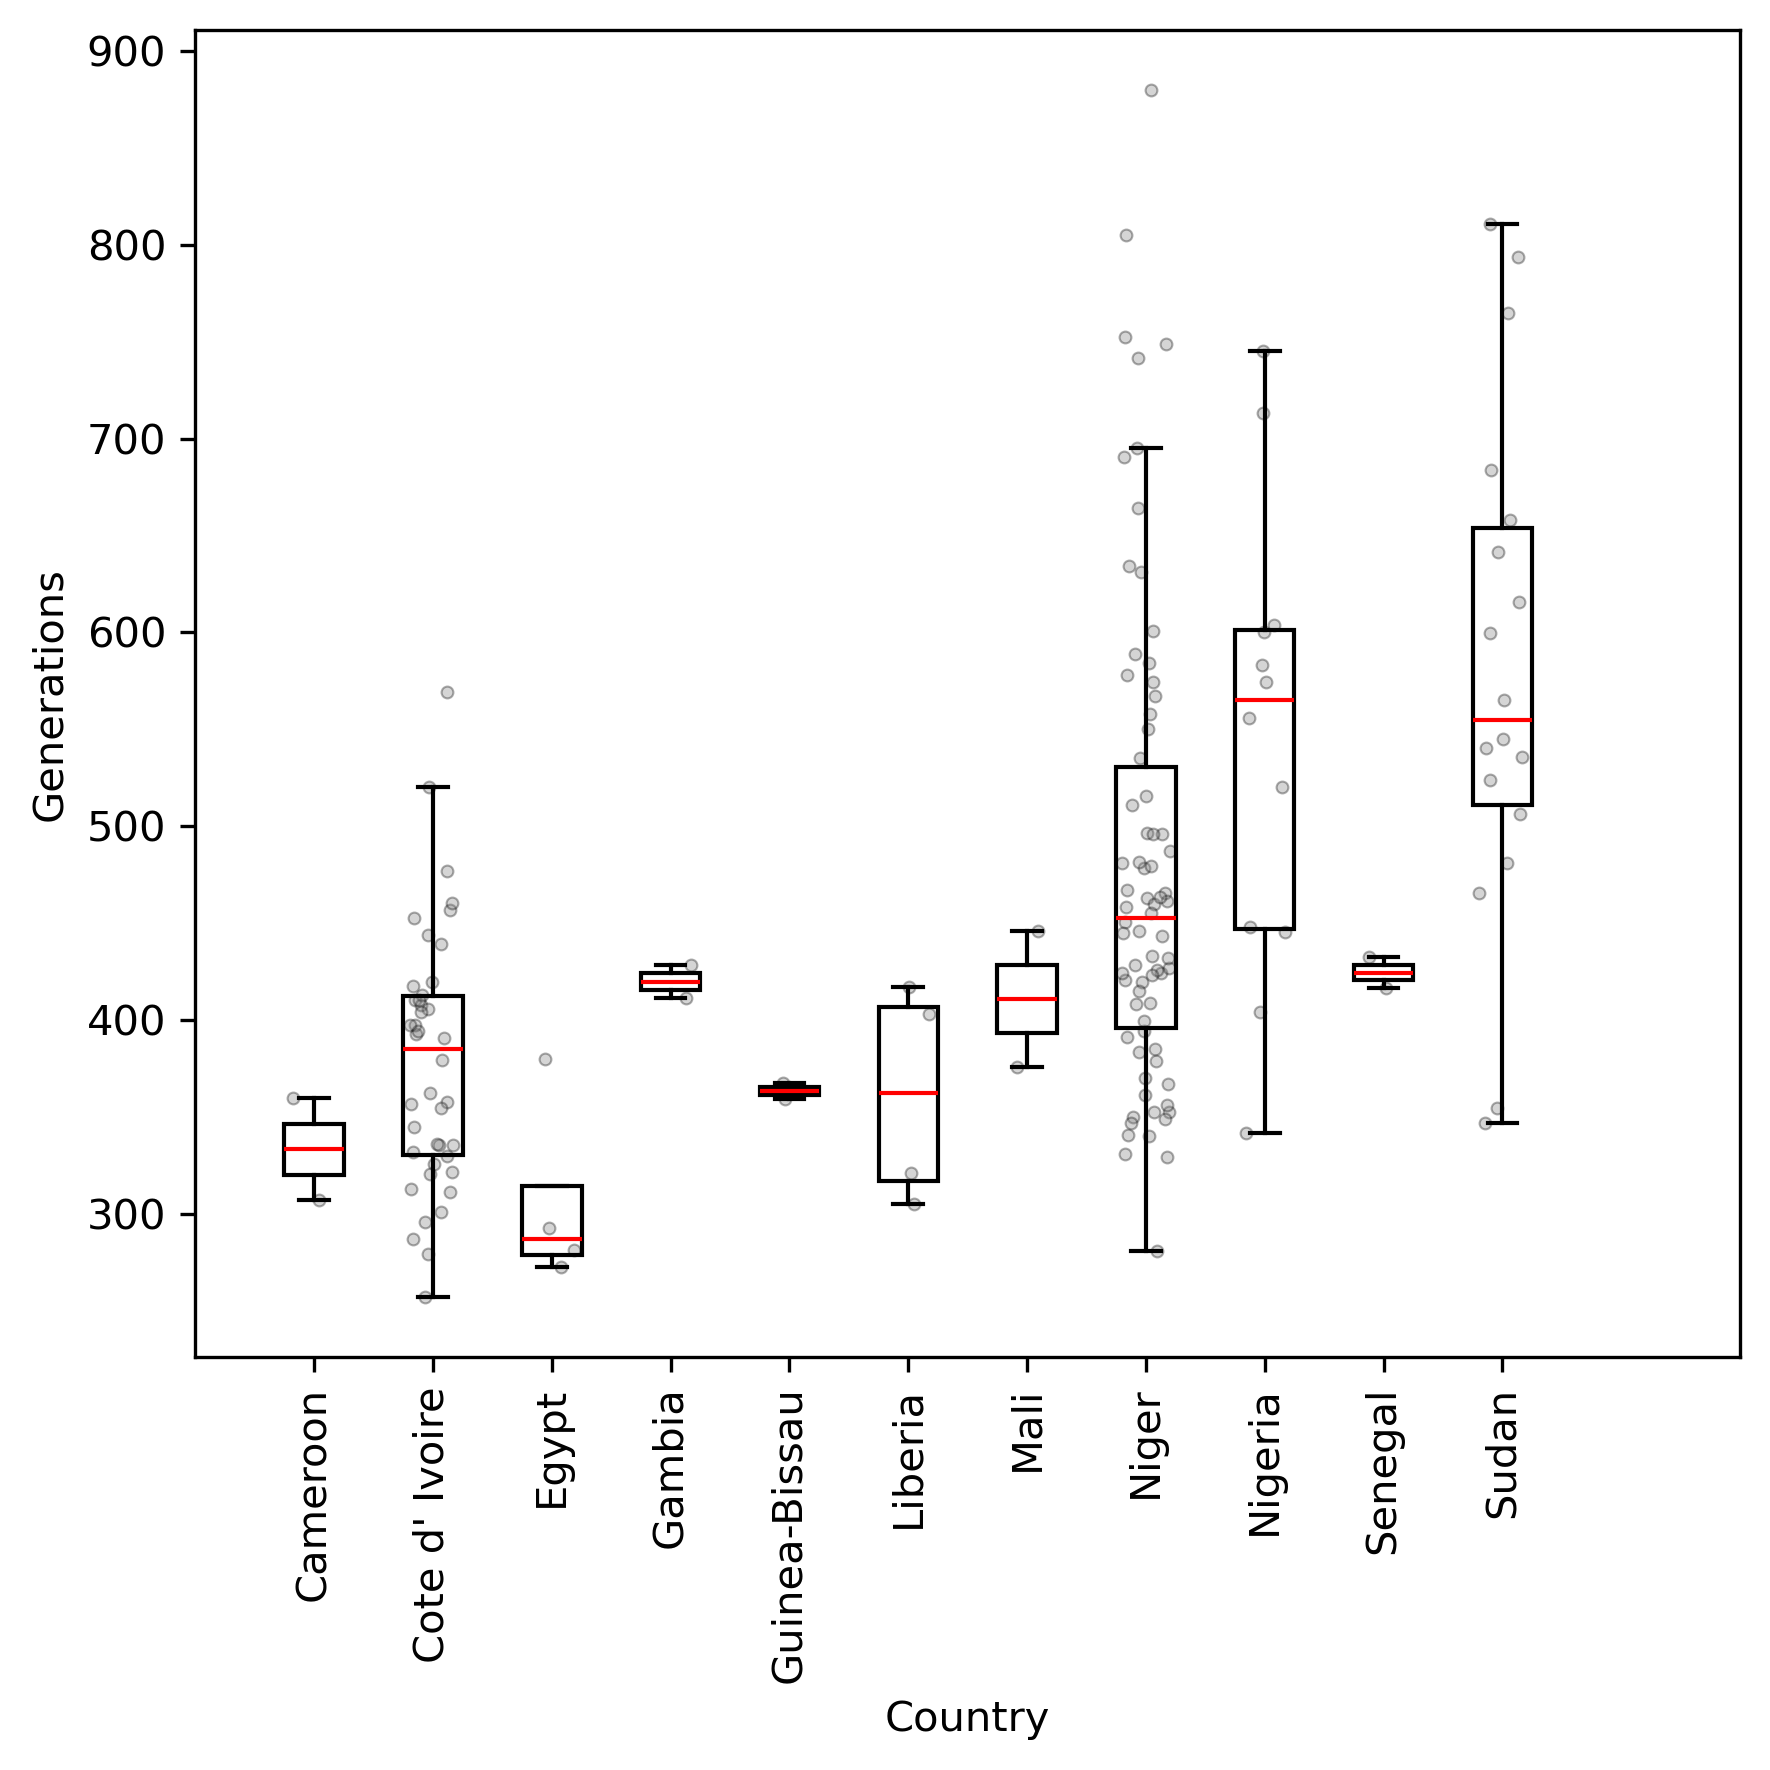

In [36]:
# Assuming nw_df is your DataFrame and it's already defined
# nw_df['country'] and nw_df['g'] columns exist

# Create a numeric column for country
nw_df["country_num"] = nw_df["country"].astype("category").cat.codes

# Define amount of jitter
jitter = 0.4

# Add jitter to 'country_num'
jittered_x = (
    nw_df["country_num"]
    + np.random.rand(len(nw_df["country_num"])) * jitter
    - jitter / 2
)

plt.figure(figsize=(6, 6), facecolor="white", dpi=300)

# Create scatter plot
plt.scatter(
    jittered_x,
    nw_df["g"],
    alpha=0.33,
    color="grey",
    edgecolor="black",
    linewidths=0.5,
    s=8,
)

# Add boxplot for each country
# Since boxplot positions are based on the unique values of 'country_num', we use those as positions.
for i in range(len(countries)):
    # Extract data for each country
    data = nw_df[nw_df["country_num"] == i]["g"]
    plt.boxplot(
        data,
        positions=[i],
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor="none", color="black"),
        medianprops=dict(color="red"),
        showfliers=False,
    )

# Add country names to x-axis
countries = [
    "Cameroon",
    "Cote d' Ivoire",
    "Egypt",
    "Gambia",
    "Guinea-Bissau",
    "Liberia",
    "Mali",
    "Niger",
    "Nigeria",
    "Senegal",
    "Sudan",
]
plt.xticks(list(range(0, len(countries))), countries, rotation="vertical")
plt.xlim([-1, len(countries) + 1])
# Set labels
plt.xlabel("Country")
plt.ylabel("Generations")

plt.tight_layout()
plt.savefig("age_estimates_box.svg")
plt.show()

In [28]:
filtered_df = nw_df.groupby("country").filter(lambda x: len(x) > 2)
filtered_df

,hap,pop,q,med_l,mean_l,min_l,max_l,g,longest_chrom,longest_start,longest_stop,sample_id,country,country_num
0,Sh_NG_eb_6_2.0,sh_nw,0.780612,69870.5,150307.043706,7422,2466909,555.593433,NC_067200.1,2804,2469713.0,Sh_NG_eb_6_2,nigeria,8
1,Sh_NG_eb_6_2.1,sh_nw,0.775547,75100.0,154587.479789,6974,2492129,520.280728,NC_067200.1,2804,2494933.0,Sh_NG_eb_6_2,nigeria,8
2,Sh_NG_ed_1_3.0,sh_nw,0.912472,55326.0,102392.017910,6635,1670464,600.257254,NC_067200.1,213953,1884417.0,Sh_NG_ed_1_3,nigeria,8
3,Sh_NG_ed_1_3.1,sh_nw,0.907377,57256.5,104907.109827,5897,1752127,583.275195,NC_067200.1,214473,1966600.0,Sh_NG_ed_1_3,nigeria,8
4,Sh_NG_ed_3_2.0,sh_nw,0.871908,60500.0,131064.582245,9188,2340942,574.460311,NC_067200.1,2804,2343746.0,Sh_NG_ed_3_2,nigeria,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,ssp_niger_libore_167.1,sh_nw,0.935915,53894.0,119025.000000,4963,2018683,600.771586,NC_067196.1,124225,2142908.0,ssp_niger_libore_167,niger,7
160,ssp_niger_libore_168.0,sh_nw,0.923197,66169.0,142645.483412,6491,2846202,496.063328,NC_067200.1,162464,3008666.0,ssp_niger_libore_168,niger,7
161,ssp_niger_libore_168.1,sh_nw,0.922371,73879.0,135811.419643,7397,2717858,444.691946,NC_067200.1,207829,2925687.0,ssp_niger_libore_168,niger,7
162,ssp_niger_libore_169.0,sh_nw,0.927961,92604.0,173197.803681,7815,2466909,352.635969,NC_067200.1,2804,2469713.0,ssp_niger_libore_169,niger,7


In [35]:
filtered_df.loc[filtered_df["country"] == "nigeria", "med_l"]

0     69870.5
1     75100.0
2     55326.0
3     57256.5
4     60500.0
5     57417.5
6     97609.0
7     82907.0
8     45065.0
9     47131.0
10    71883.0
11    72228.0
Name: med_l, dtype: float64

In [29]:
# ANOVA
model = ols("g ~ C(country)", data=filtered_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

if anova_table["PR(>F)"][0] < 0.05:
    print("Significant differences found. Proceeding with Tukey's HSD...")
    # Tukey's HSD
    tukey = pairwise_tukeyhsd(
        endog=filtered_df["g"], groups=filtered_df["country"], alpha=0.05
    )
    print(tukey)
else:
    print("No significant differences found.")

                  sum_sq     df          F        PR(>F)
C(country)  7.775748e+05    5.0  13.172885  1.295282e-10
Residual    1.747242e+06  148.0        NaN           NaN
Significant differences found. Proceeding with Tukey's HSD...


/tmp/ipykernel_52123/711369235.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table["PR(>F)"][0] < 0.05:


      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
    group1     group2 meandiff p-adj    lower    upper   reject
---------------------------------------------------------------
cote_d_ivoire   egypt -72.4858 0.7982 -236.6503  91.6787  False
cote_d_ivoire liberia -17.3698 0.9996 -181.5343 146.7947  False
cote_d_ivoire   niger  99.7787 0.0001   39.1688 160.3886   True
cote_d_ivoire nigeria 165.5611 0.0001   62.8692 268.2531   True
cote_d_ivoire   sudan 200.5624    0.0  112.1792 288.9455   True
        egypt liberia   55.116 0.9796  -166.724  276.956  False
        egypt   niger 172.2645 0.0285   11.2161 333.3129   True
        egypt nigeria 238.0469 0.0029   56.9153 419.1786   True
        egypt   sudan 273.0482 0.0002   99.6278 446.4685   True
      liberia   niger 117.1485 0.2928  -43.8999 278.1969  False
      liberia nigeria 182.9309 0.0463    1.7993 364.0626   True
      liberia   sudan 217.9322 0.0052   44.5118 391.3525   True
        niger nigeria  65.7824 0.3789  -

In [61]:
nws = g_df.loc[g_df["pop"] == "sh_nw", "g"]
ses = g_df.loc[g_df["pop"] == "sh_se", "g"]
sbs = g_df.loc[g_df["pop"] == "sb", "g"]

In [63]:
g_df.loc[g_df["pop"] == "sh_nw", "med_l"].median()

76282.5

In [66]:
nws.median()

426.41632977423694

In [102]:
nws.min()

257.0622510236241

In [101]:
nws.max()

879.637421684046

In [67]:
np.percentile(nws, 2.5)

281.5800324849554

In [68]:
np.percentile(nws, 97.5)

763.9873160385066